In [ ]:
#import ROOT
import uproot
from IPython.display import display

from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import subprocess
import os
import glob
from matplotlib.backends.backend_pdf import PdfPages
import uproot

import re 


from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from datetime import datetime

import matplotlib

import pytimber as pt


# Define the 2D Gaussian function
def gaussian_2d(X, A, x0, y0, sigma_x, sigma_y):
    x, y = X  # X is a tuple (x, y)
    return (A * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))).ravel()
# Define 1D Gaussian function
def gaussian_1d(y, A, y0, sigma_y):
    return A * np.exp(-((y - y0) ** 2) / (2 * sigma_y ** 2))

In [2]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    # Close the pentagon by appending the first vertex at the end
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    # Center in x an apply vertical offset
    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

In [3]:
def plot_MAPMTs_activity(hist, save=False, return_values=False, figsize=(8, 6)):
    edges_x = hist.axis(0).edges() 
    edges_y = hist.axis(1).edges() 
    values = hist.values() 
    fig, ax = plt.subplots(figsize=figsize)
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)  
    cbar = plt.colorbar(pcm, ax=ax)  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax.set_xlabel("Location", fontsize=14)
    ax.set_ylabel("Location", fontsize=14)
    run_number = hist.title.split('_runNb_')[1]
    ax.set_title("MAPMTs activity / run " + run_number, fontsize=16)
    ticks = np.arange(5, 50, 5)
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if save:
        plt.savefig("./Plots/MAPMTs_activity_run_" + run_number + ".png")
    if return_values:
        return fig, ax

def plot_sumActiveLayers(hist, save=False, return_values=False, figsize=(8, 6)):    

    bin_edges = hist.axis(0).edges()  
    bin_values = hist.values()  
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(bin_centers, bin_values, width=np.diff(bin_edges), align="center")

    ax.set_xlabel("Number of active layers per event", fontsize=14)
    ax.set_ylabel("Events", fontsize=14)
    run_number = hist.title.split('_runNb_')[1]
    ax.set_title("Sum of active layers / run " + run_number, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ticks = np.arange(0, 22, 2)
    ax.set_xticks(ticks)

    num_entries = np.sum(bin_values)
    edges = bin_edges[:-1] 
    mean = np.sum(edges* bin_values) / num_entries
    variance = np.sum(bin_values * (edges - mean) ** 2) / num_entries
    std_dev = np.sqrt(variance)

    legend_text = f"Entries: {num_entries}\nMean: {mean:.2f}\nStd Dev: {std_dev:.2f}"
    ax.text(0.6, 0.95, legend_text, ha="right", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

    if save:
        plt.savefig("./Plots/sumActiveLayers_run_" + run_number + ".png")

    if return_values:
        return fig, ax

In [4]:
def plot_hits(hist = None, values = None, xlim = (-23.0, 23.0), ylim = (0.0, 35.0), return_ax = True):

    if hist is not None:
        values = hist.values() 
        edges_x = hist.axis(0).edges() 
        edges_y = hist.axis(1).edges()
    elif hist is None and values is not None:
        edges_x = np.linspace(xlim[0], xlim[1], values.shape[1]+1)
        edges_y = np.linspace(ylim[0], ylim[1], values.shape[0]+1)
    
    fig, ax = plt.subplots(figsize=(10,6.5))
    ALFA_x, ALFA_y = get_pentagonal()
    ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    

    pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)#, vmax = z_max)  
    cbar = plt.colorbar(pcm, ax=ax)  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.text(0.65, 0.95,  f"N tracks {values.sum()}", ha="left", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
    
    print(values.sum())
    if return_ax == True:
        return ax

In [5]:
def plot_Tracks(hist = None, values = None, comulative = False, y_lower=None, y_upper=None, absolute_y_pos= 0, plot_fit = False, use_log_scale = False,
                z_max_2D = None, z_max_y = None, z_max_x = None,  normalize = False, print_info = False, xlim = (-23.0, 23.0), ylim = (0.0, 35.0)):
    
    if hist is not None:
        values = hist.values() 
        edges_x = hist.axis(0).edges() 
        edges_y = hist.axis(1).edges()
    elif hist is None and values is not None:
        edges_x = np.linspace(xlim[0], xlim[1], values.shape[1]+1)
        edges_y = np.linspace(ylim[0], ylim[1], values.shape[0]+1)
    
    
    if values is None:
        return
    
    edges_y = edges_y + absolute_y_pos
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    
    if use_log_scale:
        norm =  matplotlib.colors.LogNorm(vmin=1, vmax=z_max_2D)  # vmin must be > 0
    else:
        norm = None

    pcm = ax[0][0].pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap, norm=norm, vmax=None if use_log_scale else z_max_2D)

    ALFA_x, ALFA_y = get_pentagonal(absolute_y_pos*1e-3+0.003)
    ax[0][0].plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
    cbar = plt.colorbar(pcm, ax=ax[0][0])  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax[0][0].set_xlabel("x [mm]", fontsize=14)
    ax[0][0].set_ylabel("y [mm]", fontsize=14)
    ax[0][0].tick_params(axis='both', which='major', labelsize=12)
    ax[0][0].grid(linestyle=":")
    max_value = np.max(masked_values)
    bin_width_x = np.diff(edges_x)[0]  # Assuming uniform bin widths
    bin_width_y = np.diff(edges_y)[0]  # Assuming uniform bin widths

    #if isinstance(time, list):
    #    hour, minute = time[0][0], time[0][1]
    #    last_hour, last_minute = time[1][0], time[1][1]
    #else:
    #    hour, minute = time[0], time[1]
    #    last_minute = minute  #+ 1 if minute < 59 else 0
    #    last_hour = hour # + 1 if minute == 59 else hour f"{h:02d}:{m:02d}"
    #if comulative:
    #    hour = 13
    #    minute = 17
    #ax[0][0].text(0.65, 0.95,  f"N tracks {values.sum()}\nTime {hour:02d}:{minute:02d} - {last_hour:02d}:{last_minute:02d}", ha="left", va="top", transform=ax[0][0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

    #values_with_overflow = np.pad(values, ((1, 1), (0, 0)), mode='constant', constant_values=0)  # Padding for underflow and overflow
    y_projection = np.sum(values, axis=0) 
    bin_centers_y = (edges_y[:-1] + edges_y[1:]) / 2
    ax[0][1].bar(edges_y[:-1], y_projection, width=np.diff(edges_y), align="edge", alpha=0.6)
    ax[0][1].set_xlabel("y [mm]", fontsize=14)
    ax[0][1].set_ylabel("Counts", fontsize=14)
    ax[0][1].tick_params(axis='both', which='major', labelsize=12)
    if z_max_y is not None:
        ax[0][1].set_ylim(0, z_max_y)

    x_projection = np.sum(values, axis=1)  # sum over y → projection along x
    bin_centers_x = 0.5 * (edges_x[:-1] + edges_x[1:])  # Compute bin centers
    ax[1][0].bar(edges_x[:-1], x_projection, width=np.diff(edges_x), align="edge", alpha=0.6)
    ax[1][0].set_xlabel("x [mm]", fontsize=14)
    ax[1][0].set_ylabel("Counts", fontsize=14)
    ax[1][0].tick_params(axis='both', which='major', labelsize=12)
    if z_max_x is not None:
        ax[1][0].set_ylim(0, z_max_x)

    if print_info:
        print("Maximum value in the bins:", max_value)
        print("Bin width along y-axis:", bin_width_y)
        print("Bin width along x-axis:", bin_width_x)
        print("Maximum in x projection:", np.max(x_projection))
        print("Maximum in y projection:", np.max(y_projection))


    cumulative_y_projection = np.cumsum(np.array(y_projection)[::-1])[::-1]
    if normalize:
        cumulative_y_projection = cumulative_y_projection / np.max(cumulative_y_projection)
    ax[1][1].plot(edges_y[:-1], cumulative_y_projection, linewidth=2, label="Cumulative Y Projection")
    ax[1][1].tick_params(axis='both', which='major', labelsize=12)

    if y_lower is not None and y_upper is not None:

        # Filter in y
        y_mask = (bin_centers_y >= y_lower) & (bin_centers_y <= y_upper)
        values_filtered = values[:, y_mask] 
        edges_y_filtered = edges_y[np.r_[np.where(y_mask)[0], np.where(y_mask)[0][-1] + 1]]
        y_centers_filt = 0.5 * (edges_y_filtered[:-1] + edges_y_filtered[1:])
        y_projection_filt = np.sum(values_filtered, axis=0)  # Sum over x-axis
        x_projection_filt = np.sum(values_filtered, axis=1)  # Sum over y-axis
        ax[0][0].axhline(y_lower, color="red", linestyle="--", label="Lower limit")
        ax[0][0].axhline(y_upper, color="red", linestyle="--", label="Upper limit")

        # Create a 2D meshgrid
        X, Y = np.meshgrid(bin_centers_x, y_centers_filt, indexing="ij")  # Ensure correct shape
        # Flatten data for fitting
        xdata = np.vstack((X.ravel(), Y.ravel()))  
        zdata = values_filtered.ravel()  # Use filtered values
        nonzero_mask = zdata > 0
        xdata = xdata[:, nonzero_mask]
        zdata = zdata[nonzero_mask]
        # Fit the 2D Gaussian function
        initial_guess = (np.max(zdata), np.mean(x_projection_filt), np.mean(y_projection_filt), np.std(x_projection_filt), np.std(x_projection_filt))
        popt, pcov = curve_fit(gaussian_2d, xdata, zdata, p0=initial_guess)
        A_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit = popt
        print(f"2D Gauss Fit Parameters:\n A={A_fit}, x0={x0_fit}, y0={y0_fit}, sigma_x={sigma_x_fit}, sigma_y={sigma_y_fit}")
        #ax[0][0].plot(x0_fit, y0_fit, "ro", markersize=10, label="Fit center")

        # Compute Y Projection 
        y_fit = np.linspace(np.min(y_centers_filt), np.max(y_centers_filt), 100)
        gaussian_curve_y = gaussian_1d(y_fit, 1, y0_fit, sigma_y_fit)  #
        # Compute normalization factor: Match the total area of histogram and Gaussian
        hist_integral_y = np.sum(y_projection_filt * np.diff(edges_y_filtered))  # Approximate integral of histogram
        gaussian_integral_y = np.trapz(gaussian_curve_y, y_fit)  # Integral of Gaussian using trapezoidal rule
        A_rescaled_y = hist_integral_y / gaussian_integral_y  # Rescale amplitude properly
        # Recalculate the Gaussian with the correct amplitude
        gaussian_curve_y = gaussian_1d(y_fit, A_rescaled_y, y0_fit, sigma_y_fit)
        ax[0][1].plot(y_fit, gaussian_curve_y, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        ax[0][1].axvline(y_upper)
        ax[0][1].axvline(y_lower)
        legend_text = f"Fit mean: {y0_fit:.2f} mm\nFit sigma: {sigma_y_fit:.2f} mm"
        ax[0][1].text(0.75, 0.95, legend_text, ha="right", va="top", transform=ax[0][1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

        # Compute X fit 
        x_fit = np.linspace(np.min(bin_centers_x), np.max(bin_centers_x), 100)
        gaussian_curve_x = gaussian_1d(x_fit, 1, x0_fit, sigma_x_fit)  #
        hist_integral_x = np.sum(x_projection_filt * np.diff(edges_x))
        gaussian_integral_x = np.trapz(gaussian_curve_x, x_fit)  # Integral of Gaussian using trapezoidal rule
        A_rescaled_x = hist_integral_x / gaussian_integral_x  # Rescale amplitude properly
        gaussian_curve_x = gaussian_1d(x_fit, A_rescaled_x, x0_fit, sigma_x_fit)
        ax[1][0].plot(x_fit, gaussian_curve_x, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        legend_text = f"Fit mean: {x0_fit:.2f} mm\nFit sigma: {sigma_x_fit:.2f} mm"
        ax[1][0].text(0.85, 0.95, legend_text, ha="right", va="top", transform=ax[1][0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

        ax[1][1].axvline(y_lower, color="red", linestyle="--", label="Mean")
        cum_to_fit_erf = cumulative_y_projection[edges_y[:-1] >= y_lower]
        y_to_fit_erf = edges_y[:-1][edges_y[:-1] >= y_lower]
        def erfunc(x,a,b,c,d):
            return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))
        
        param0 = [np.max(cum_to_fit_erf), np.min(cum_to_fit_erf), np.mean(y_to_fit_erf), np.std(y_to_fit_erf)]
        params, extras = opt.curve_fit(erfunc, y_to_fit_erf, cum_to_fit_erf,  p0=param0)
        print("ERF Fit parameters:", params)
        ax[1][1].plot(edges_y[:-1], erfunc(edges_y[:-1], *params), linewidth=2, label="ERF Fit")
        legend_text = f"Fit mean: {params[2]:.2f} mm\nFit sigma: {params[3]:.2f} mm"
        ax[1][1].text(0.85, 0.95, legend_text, ha="right", va="top", transform=ax[1][1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
        
        if plot_fit:
            ax[0][0].plot(popt[1], popt[2], 'ro', markersize=2, label='Gaussian Fit Center')
            ellipse = matplotlib.patches.Ellipse((popt[1], popt[2]), width=6*popt[3], height=6*popt[4],
                                                    edgecolor='g', facecolor='none', linewidth=2, zorder=4)
            ax[0][0].add_patch(ellipse)

In [32]:
file_path = 'runs.txt'

def get_runs(file_path):

    with open(file_path, 'r') as file:
        clean_text = ' '.join(file.read().splitlines()).strip()
        file_names = clean_text.split()
        file_list = list(file_names)


    run_numbers = []
    timestamps = []


    for file_name in file_list:

        match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)
        if match:
            run_number = int(match.group(1))

        parts = file_name.split('-')
        year = int(parts[1])
        month = int(parts[2])
        day = int(parts[3])
        if len(parts) > 6:
            hour = parts[4]
            minute = parts[5]
            second = parts[6].split('.')[0]
        else:
            hour = parts[4].split('.')[0]
            minute = "00"
            second = "00"

        timestamp = f"{year}-{month}-{day} {hour}:{minute}:{second}"
        run_numbers.append(run_number)
        timestamps.append(timestamp)


    df_all_files = pd.DataFrame({'Run Number': run_numbers, 'Timestamp': timestamps})

    df_runs = df_all_files.groupby('Run Number')['Timestamp'].agg(['min', 'max'])
    df_runs = df_runs.rename(columns={'min': 'start_time', 'max': 'end_time'})

    runs_info = df_runs.to_dict(orient='index')
    
    return df_all_files, df_runs, runs_info, file_list



In [7]:
def find_run_number(df, timestamp_str):
    df2 = df.copy()
    df2['start_time'] = pd.to_datetime(df2['start_time'])
    df2['end_time'] = pd.to_datetime(df2['end_time'])
    timestamp = pd.to_datetime(timestamp_str)

    match = df2[(df2['start_time'] <= timestamp) & (df2['end_time'] >= timestamp)]

    if not match.empty:
        return match.index[0] 
    else:
        print("TFT was not running at tht time (check end time!)")
        return None


In [8]:
def find_filename_by_time(target_time_str, file_list, final_info):
   
    target_time = datetime.strptime(target_time_str, "%Y-%m-%d %H:%M:%S")
  
    for run_number, time_range in final_info.items():
        start = datetime.strptime(time_range['start_time'], "%Y-%m-%d %H:%M:%S")
        end = datetime.strptime(time_range['end_time'], "%Y-%m-%d %H:%M:%S")
        
        if start <= target_time <= end:
            for file_name in file_list:
                if f"r{run_number}_" in file_name:
                    parts = file_name.split('-')
                    year = int(parts[1])
                    month = int(parts[2])
                    day = int(parts[3])
                    if len(parts) > 6:
                        hour = parts[4]
                        minute = parts[5]
                        second = parts[6].split('.')[0]
                    else:
                        hour = parts[4].split('.')[0]
                        minute = "00"
                        second = "00"
                    file_time = datetime(year, month, day, int(hour), int(minute), int(second))

                    if file_time == target_time:
                        return file_name
                    
            print("Exact time not found, looking for the closest..")
            closest_file = None
            closest_diff = float('inf')
            for file_name in file_list:
                if f"r{run_number}_" in file_name:
                    parts = file_name.split('-')
                    year = int(parts[1])
                    month = int(parts[2])
                    day = int(parts[3])
                    if len(parts) > 6:
                        hour = parts[4]
                        minute = parts[5]
                        second = parts[6].split('.')[0]
                    else:
                        hour = parts[4].split('.')[0]
                        minute = "00"
                        second = "00"
                    file_time = datetime(year, month, day, int(hour), int(minute), int(second))
                    diff = abs((file_time - target_time).total_seconds())
                    if diff < closest_diff:
                        closest_diff = diff
                        closest_file = file_name
            return closest_file

    return None  # No match found


In [9]:
def find_run_by_time(query_time, run_df_orig):
    
    run_df = run_df_orig.copy()
    run_df['start_time'] = pd.to_datetime(run_df['start_time'])
    run_df['end_time'] = pd.to_datetime(run_df['end_time'])

    query_time = pd.to_datetime(query_time)
    mask = (run_df['start_time'] <= query_time) & (query_time <= run_df['end_time'])
    return run_df.index[mask].tolist()

def filter_runs_by_time_range(start, end, run_df_orig):
    run_df = run_df_orig.copy()
    run_df['start_time'] = pd.to_datetime(run_df['start_time'])
    run_df['end_time'] = pd.to_datetime(run_df['end_time'])
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    mask = (run_df['start_time'] <= end) & (run_df['end_time'] >= start)
    
    return run_df[mask]

def calculate_time_intervals(df):
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()
    
    return df

def time_difference(t1, t2):
    
    format_str = "%Y-%m-%d %H:%M:%S"
    dt1 = datetime.strptime(t1, format_str)
    dt2 = datetime.strptime(t2, format_str)
    
    return abs(dt2 - dt1)

In [10]:
hist_dict = {
    
    1: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks1",
    2: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks2",
    3: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks3",
    4: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks4",
    5: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks5",
    6: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks6",
    7: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks7",
    8: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks8",
    9: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks9",
    10: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks10",
    11: "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks11",
    "multi": "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracksMult",
    "tot": "Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks"
    
}

In [4]:
#fn = "./merged_gnams/TOTAL_gnam_1750484801.root"
fn = "./merged_gnams/TOTAL_gnam_1750607184.root"
file = uproot.open(fn)

In [46]:
for key, obj in file.items():
    print(f"Key: {key}")
    print(f"  Type: {type(obj)}")

    # If it's a TTree, print its branches
    if isinstance(obj, uproot.behaviors.TTree.TTree):
        print("  Branches:")
        for branch in obj.keys():
            print(f"    - {branch}")

Key: Histogramming;1
  Type: <class 'uproot.reading.ReadOnlyDirectory'>
Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice;1
  Type: <class 'uproot.reading.ReadOnlyDirectory'>
Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG;1
  Type: <class 'uproot.reading.ReadOnlyDirectory'>
Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DataCollectionTime_ms;1
  Type: <class 'uproot.models.TH.Model_TH1I_v3'>
Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DataCollectionTime_ms_recent;1
  Type: <class 'uproot.models.TH.Model_TH1I_v3'>
Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcAvailableCredits;1
  Type: <class 'uproot.models.TH.Model_TH1I_v3'>
Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcAvailableCredits_recent;1
  Type: <class 'uproot.models.TH.Model_TH1I_v3'>
Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcResponseTime_us;1
  Type: <class 'uproot.models.TH.Model_TH2I_v4'>
Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcResponseTime_us_recent;1
  Type: <class 'uproot.models.TH

In [17]:
n = []
big_matrix = np.zeros((1500, 1500))
for i in range(1,12):
    hist = file[hist_dict[i]]
    big_matrix = big_matrix + hist.values()
    val = np.sum(hist.values())
    print(i,": ", np.sum(hist.values()))
    n.append(val)

1 :  69972
2 :  3803592
3 :  5699369
4 :  5376510
5 :  4783725
6 :  1032
7 :  744
8 :  744
9 :  864
10 :  1056
11 :  720


In [18]:
sum(n)

19738328

In [19]:
hist = file[hist_dict["tot"]]
val = np.sum(hist.values())
val

26073975

In [20]:
sum(n) - val

-6335647

In [21]:
values = hist.values()

In [22]:
hist.values().shape

(1500, 1500)

26073975


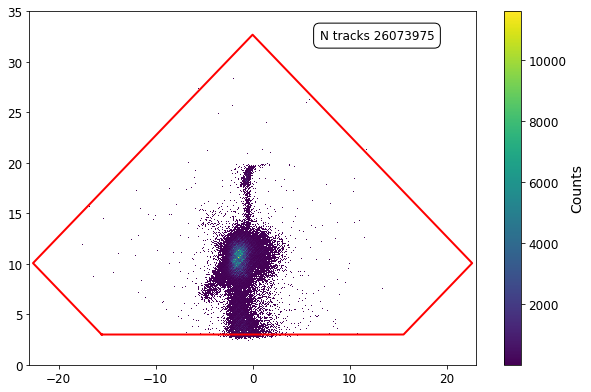

In [24]:
plot_hits(file[hist_dict["tot"]])

19738328.0


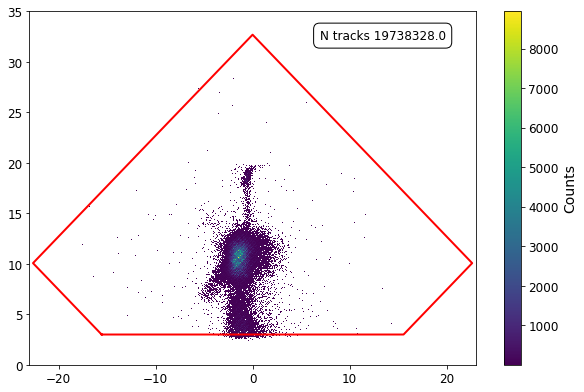

In [25]:
plot_hits(values = big_matrix)

0


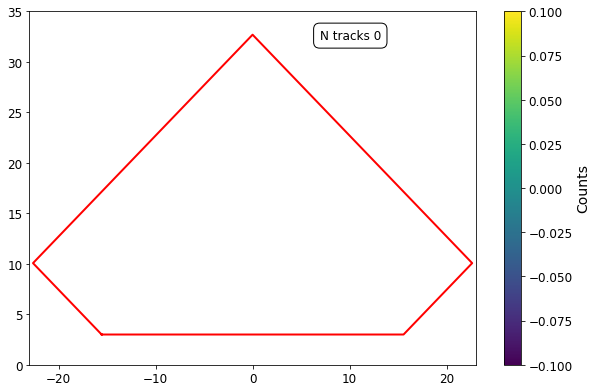

In [21]:
plot_hits(file[hist_dict["multi"]])

69972
3803592
5699369
5376510
4783725
1032
744
744
864
1056
720


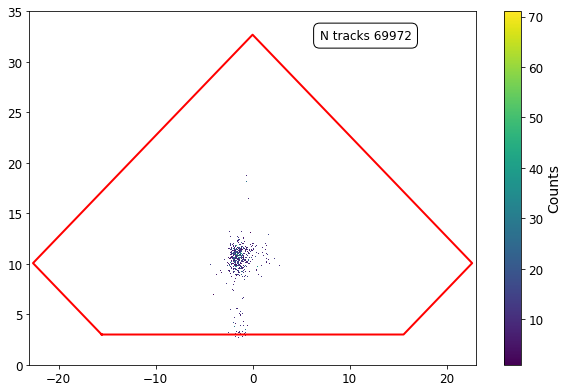

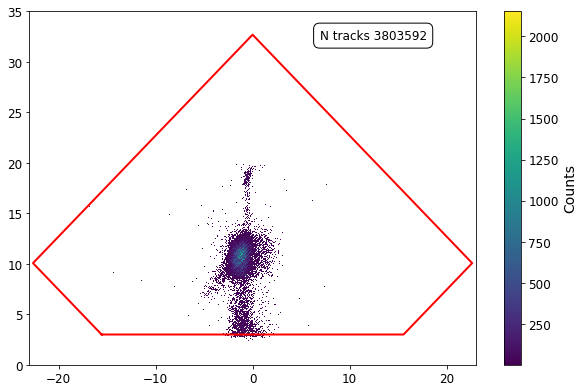

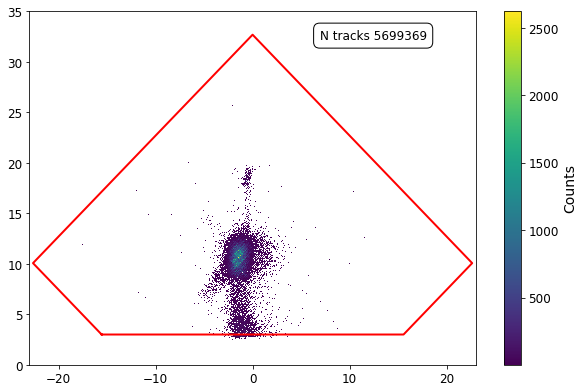

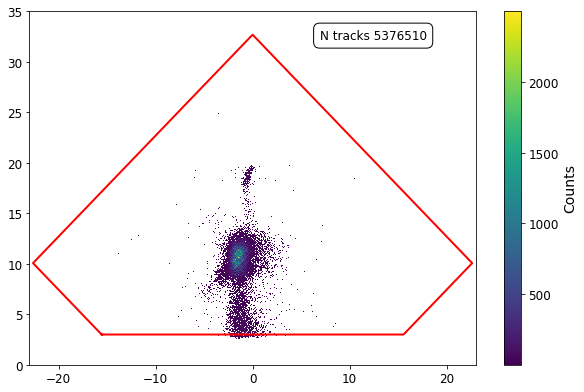

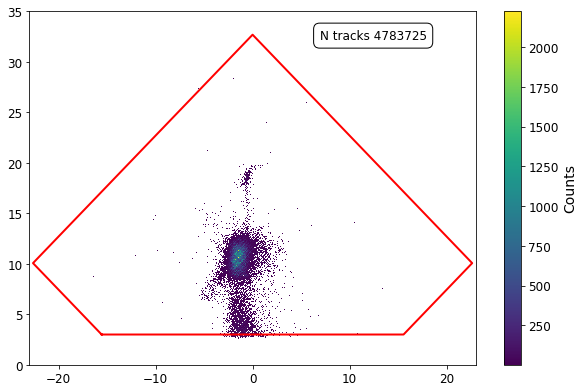

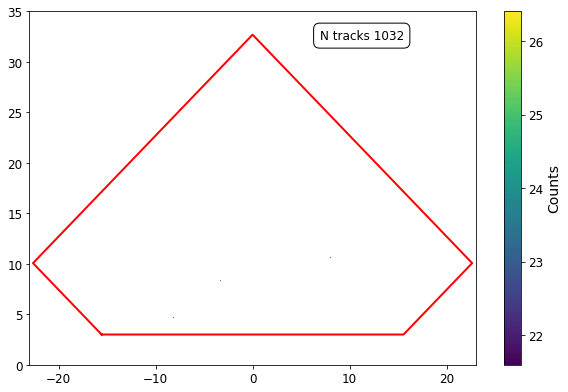

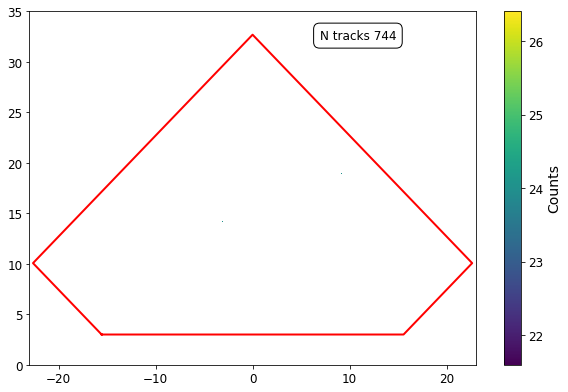

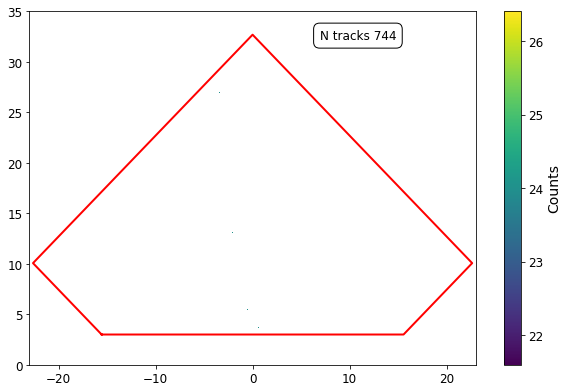

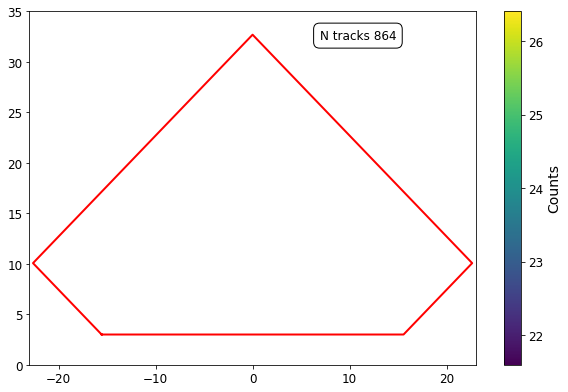

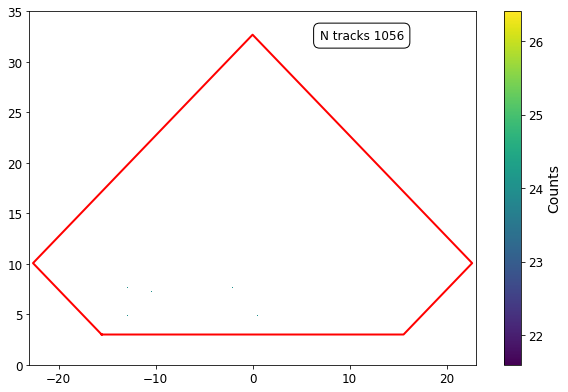

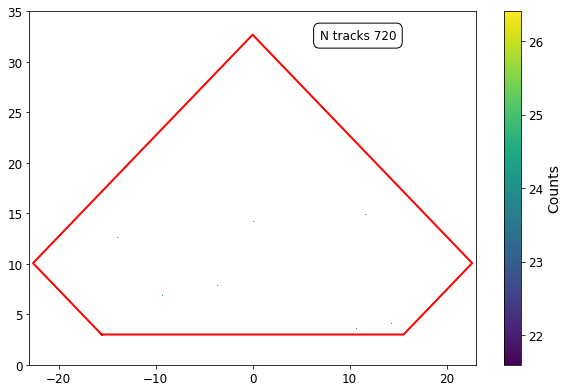

In [22]:
for i in range(1,12):
    plot_hits(file[hist_dict[i]])

In [5]:
time_difference('2025-06-22 15:46:25', '2025-06-22 15:47:59')

datetime.timedelta(seconds=94)

753897


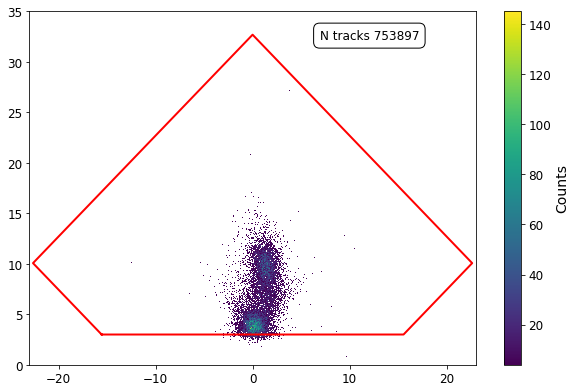

In [28]:
fn = "./tmp_gnams/r1750484801_33-2025-06-21-08-18-01_64.root"
file = uproot.open(fn)
plot_hits(file[hist_dict["tot"]])

762976


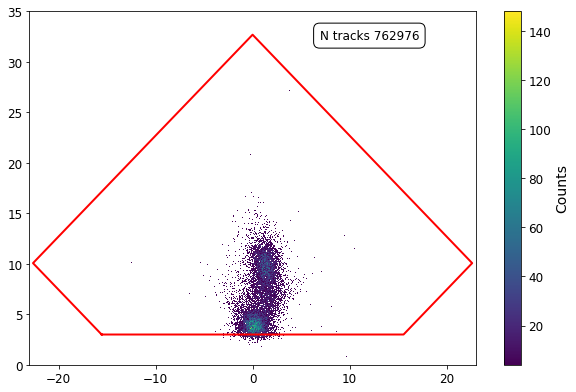

In [29]:
fn = "./tmp_gnams/r1750484801_33-2025-06-21-08-18-23_65.root"
file = uproot.open(fn)
plot_hits(file[hist_dict["tot"]])

In [30]:
762976 - 753897

9079

46915


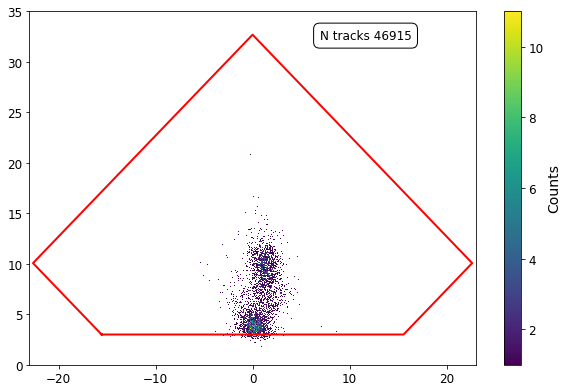

In [31]:
fn = "./tmp_gnams/r1750484801_33-2025-06-21-08-18-23_65.root"
file = uproot.open(fn)
plot_hits(file[hist_dict["tot"]+"_recent"])

46915


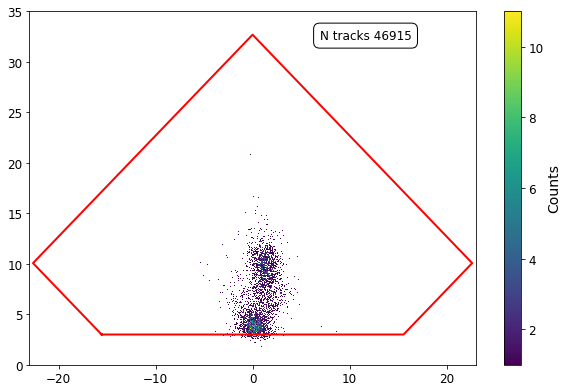

In [32]:
fn = "./tmp_gnams/r1750484801_34-2025-06-21-08-18-46_66.root"
file = uproot.open(fn)
plot_hits(file[hist_dict["tot"]+"_recent"])

772304


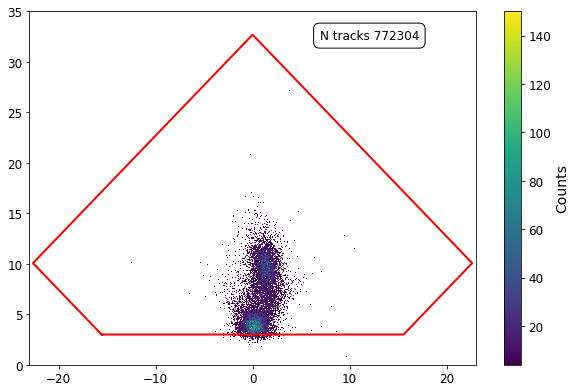

In [33]:
fn = "./tmp_gnams/r1750484801_34-2025-06-21-08-18-46_66.root"
file = uproot.open(fn)
plot_hits(file[hist_dict["tot"]])

In [34]:
772304 - 762976

9328

2D Gauss Fit Parameters:
 A=42.93355928900137, x0=1.331401350725915, y0=9.551502812975695, sigma_x=-0.8951632175085769, sigma_y=-1.826309514861812
ERF Fit parameters: [ 0.2278014  -0.45473567  9.39457255  1.67677262]


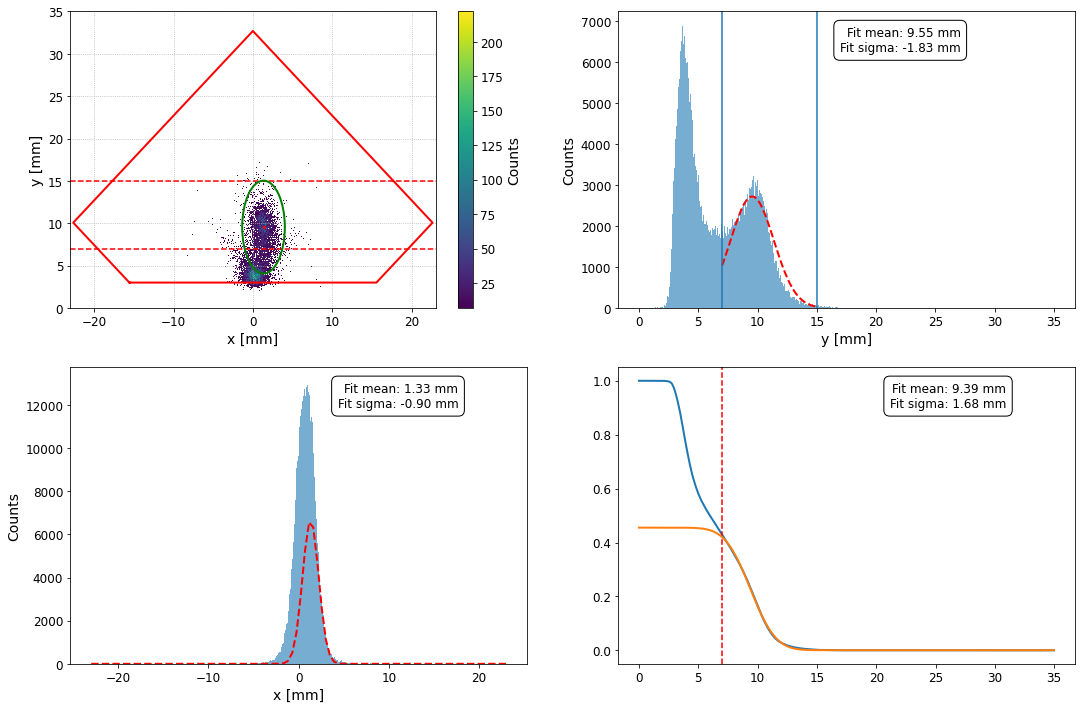

In [24]:
plot_Tracks(file[hist_dict["tot"]], y_lower = 7, y_upper = 15, plot_fit = True, normalize = True)

In [36]:
file_path = 'runs.txt'
df_all_files, df_runs, runs_info, file_list = get_runs(file_path)

In [14]:
runs_info[1750607184]

{'start_time': '2025-6-22 17:46:26', 'end_time': '2025-6-22 17:55:22'}

In [15]:
find_run_number(df_runs, '2025-6-22 17:57:00' )

TFT was not running at tht time (check end time!)


In [16]:
find_run_number(df_runs, '2025-6-22 17:55:00' )

1750607184

In [37]:
find_filename_by_time('2025-6-22 17:55:22', file_list, runs_info)

'r1750607184_6-2025-06-22-17-55-22.root'

In [16]:
df_runs.start_time.iloc[0]

'2025-4-20 10:00:00'

In [17]:
fn ="/eos/project-t/twocryst/data/tft/snapshots/" + 'r1750607184_6-2025-06-22-17-55-22.root'
file = uproot.open(fn)

0


<Axes: >

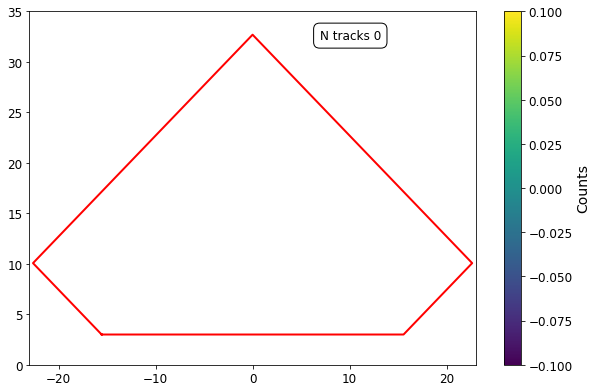

In [18]:
plot_hits(file[hist_dict[1]+"_recent"])

In [61]:
fn = "./all_gnams/gnamFiles/gnam_1750607184.root"
file = uproot.open(fn)

In [67]:
file["SHIFT"]["ALFA_common"].keys()

['ALFA_MD_CTPInputRate;1',
 'ALFA_OD_CTPInputRate;1',
 'BCXErrorsAtMB;1',
 'BCXatROD_0;1',
 'BCXatROD_1;1',
 'TriggersInBunchGroups;1',
 'alfaTriggersAtCTP;1',
 'dataQAssess15;1',
 'dataQAssess15NbTracks;1',
 'dataQAssess18;1',
 'dataQAssess18NbTracks;1',
 'maxActiveLayersPerLB;1',
 'pmtSynchErrors;1',
 'pmtSynchErrors_LB;1',
 'rodSynchErrors;1',
 'triggerPattern;1']

In [68]:
file["SHIFT"]["RP_5"].keys()

['2DMultiplicity_Det5_Side0_Layer0;1',
 '2DMultiplicity_Det5_Side0_Layer1;1',
 '2DMultiplicity_Det5_Side0_Layer2;1',
 '2DMultiplicity_Det5_Side1_Layer0;1',
 '2DMultiplicity_Det5_Side1_Layer1;1',
 '2DMultiplicity_Det5_Side1_Layer2;1',
 'ALFA_ANY_EMPTY_TracksReco;1',
 'ALFA_ANY_EMPTY_TracksReco_10LB;1',
 'ALFA_ANY_EMPTY_TracksReco_1LB;1',
 'ALFA_ANY_EMPTY_TracksReco_60LB;1',
 'ALFA_ANY_UNPAIR_ISO_TracksReco;1',
 'ALFA_ANY_UNPAIR_ISO_TracksReco_10LB;1',
 'ALFA_ANY_UNPAIR_ISO_TracksReco_1LB;1',
 'ALFA_ANY_UNPAIR_ISO_TracksReco_60LB;1',
 'AllTracksReco;1',
 'AllTracksRecoAggr;1',
 'BCXatMB;1',
 'Distance_5_6_Side0;1',
 'Distance_5_6_Side1;1',
 'ELAST15_TracksReco;1',
 'ELAST15_TracksReco_10LB;1',
 'ELAST15_TracksReco_1LB;1',
 'ELAST15_TracksReco_60LB;1',
 'ELAST15_calib_TracksReco;1',
 'ELAST15_calib_TracksReco_10LB;1',
 'ELAST15_calib_TracksReco_1LB;1',
 'ELAST15_calib_TracksReco_60LB;1',
 'ELAST18_TracksReco;1',
 'ELAST18_TracksReco_10LB;1',
 'ELAST18_TracksReco_1LB;1',
 'ELAST18_TracksRe

In [69]:
file["EXPERT"]["RP_5"].keys()

['AvgtrgChargLB_1;1',
 'AvgtrgChargLB_2;1',
 'MAPMTs_activity;1',
 'MAPMTs_activityNoSE;1',
 'MAPMTs_activityNoSE_1LB;1',
 'MAPMTs_activityOnlySE;1',
 'MAPMTs_activityOnlySE_1LB;1',
 'MAPMTs_activity_1LB;1',
 'PMFvsMAPMT;1',
 'PMFvsMAROC;1',
 'PMT_1;1',
 'PMT_10;1',
 'PMT_11;1',
 'PMT_12;1',
 'PMT_13;1',
 'PMT_14;1',
 'PMT_15;1',
 'PMT_16;1',
 'PMT_17;1',
 'PMT_18;1',
 'PMT_19;1',
 'PMT_2;1',
 'PMT_20;1',
 'PMT_21;1',
 'PMT_22;1',
 'PMT_23;1',
 'PMT_3;1',
 'PMT_4;1',
 'PMT_5;1',
 'PMT_6;1',
 'PMT_7;1',
 'PMT_8;1',
 'PMT_9;1',
 'sumAllHits;1',
 'sumAllHitsMBTriggered;1',
 'trgChargLB_1;1',
 'trgChargLB_2;1',
 'trgChargPerLB_1;1',
 'trgChargPerLB_2;1']

In [70]:
file["EXPERT"]["ALFA_common"].keys()

['decodeTiming;1', 'geoCoinc;1', 'histoTiming;1', 'simpleCoinc;1']

In [72]:
file["EXPERT"]["RP_5"]["PMT_10"]

<TH1I (version 3) at 0x7fbbb568db90>

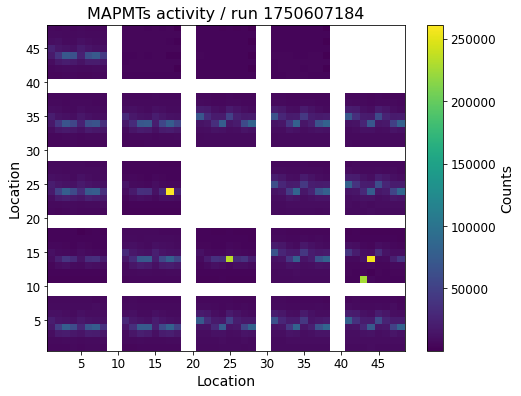

In [74]:
plot_MAPMTs_activity(file["EXPERT"]["RP_5"]['MAPMTs_activity'])

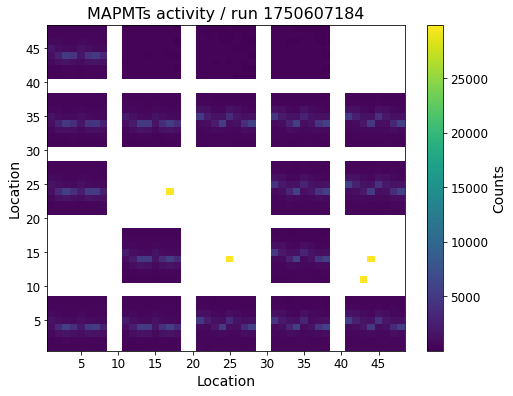

In [77]:
plot_MAPMTs_activity(file["EXPERT"]["RP_5"]['MAPMTs_activity_1LB'])

In [20]:
df_runs

,start_time,end_time
Run Number,,
1745130431,2025-4-20 10:00:00,2025-4-20 10:00:00
1745138178,2025-4-20 10:00:00,2025-4-20 10:00:00
1745142439,2025-4-20 12:00:00,2025-6-21 07:54:32
1745147836,2025-4-20 13:00:00,2025-4-20 17:00:00
1750484801,2025-6-21 07:56:26,2025-6-21 08:34:46
...,...,...
1750615822,2025-6-22 20:10:24,2025-6-22 20:21:16
1750616771,2025-6-22 20:26:13,2025-6-22 20:51:04
1750618388,2025-6-22 20:53:11,2025-6-22 20:57:50


In [23]:
MD_runs = filter_runs_by_time_range("2025-06-21 20:00:00", "2025-06-22 23:59:59", df_runs).index.to_list()

Missing file for run 1750534124
Missing file for run 1750535921
Missing file for run 1750536221
Missing file for run 1750537188
Missing file for run 1750537668
Missing file for run 1750537800
Empty histogram for run 1750540230
Missing file for run 1750541720
Empty histogram for run 1750541947
Empty histogram for run 1750542809
Empty histogram for run 1750543939
Missing file for run 1750544604
Missing file for run 1750544963
Empty histogram for run 1750545288
Empty histogram for run 1750547938
Empty histogram for run 1750548909
Empty histogram for run 1750549591
Missing file for run 1750588528
Missing file for run 1750588675
Missing file for run 1750589655
Missing file for run 1750590046
Missing file for run 1750592719
Missing file for run 1750592892
Missing file for run 1750594018
Missing file for run 1750594599
Missing file for run 1750598647
Missing file for run 1750598934
Missing file for run 1750599213
Missing file for run 1750599857
Missing file for run 1750600315
Missing file for

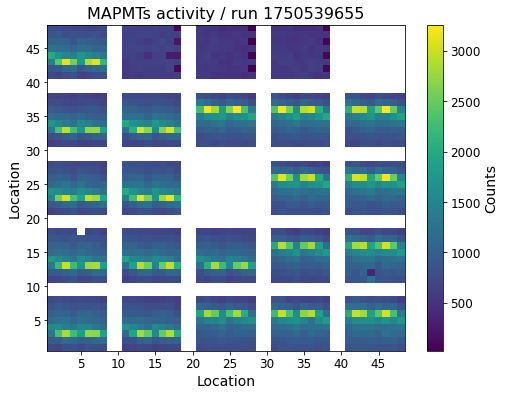

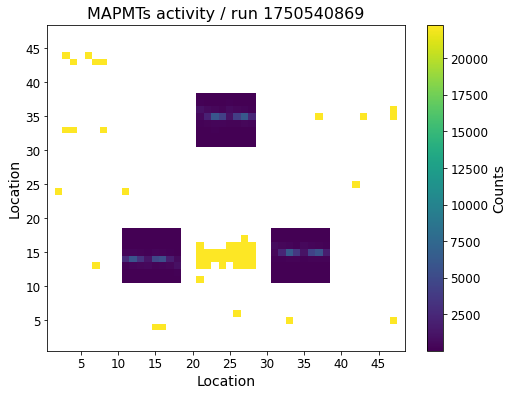

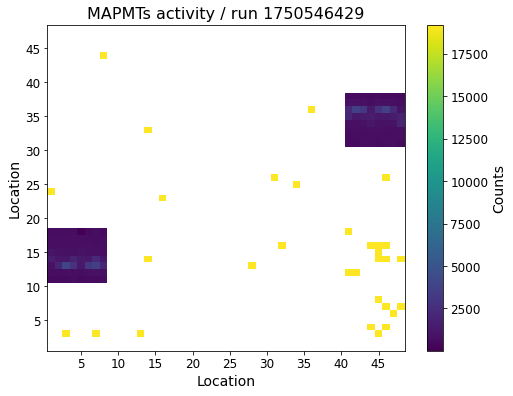

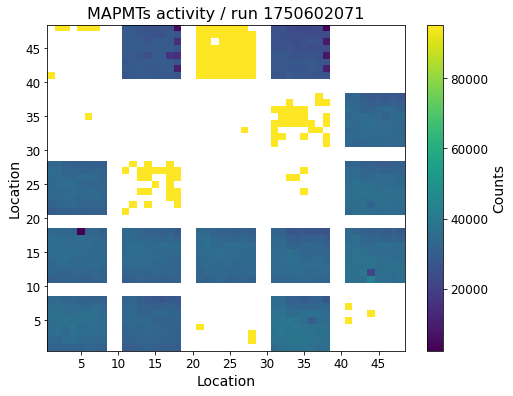

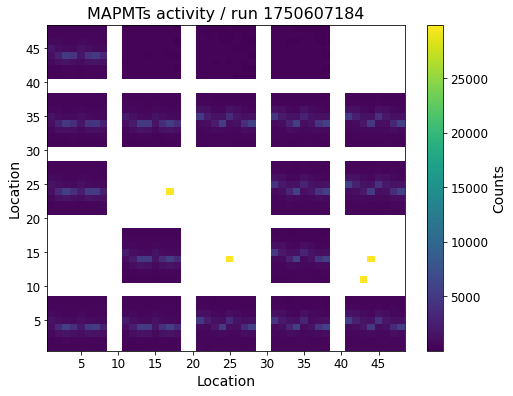

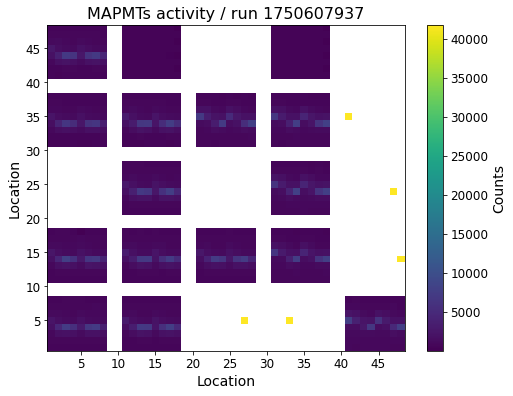

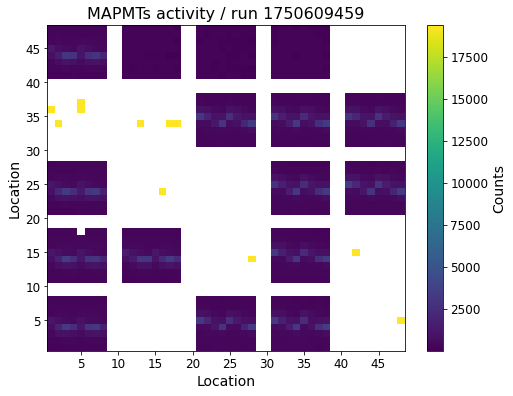

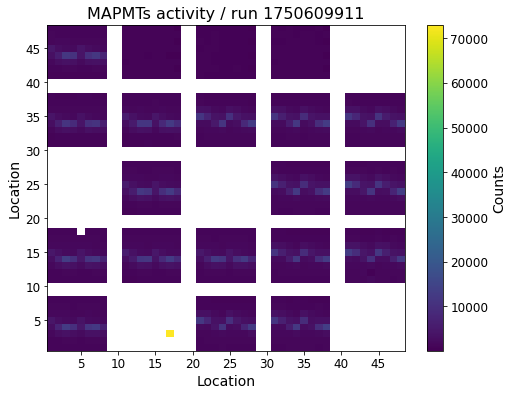

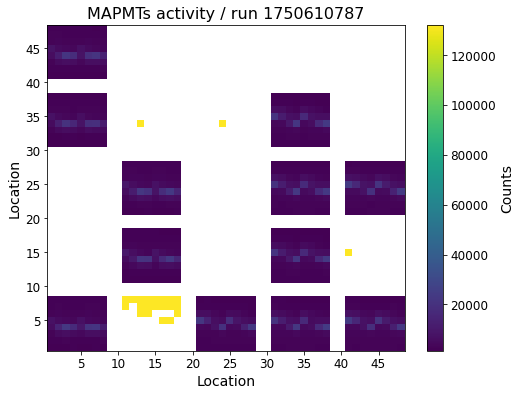

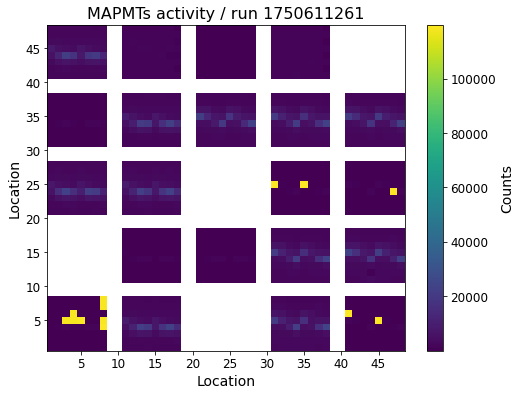

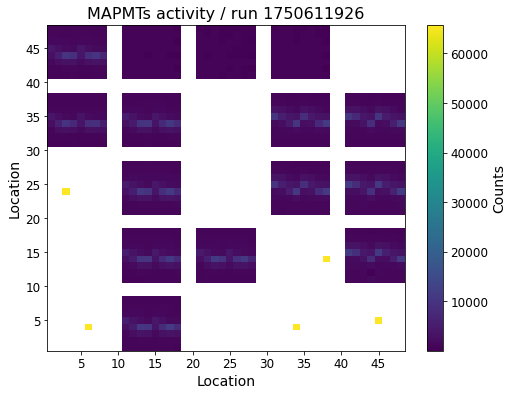

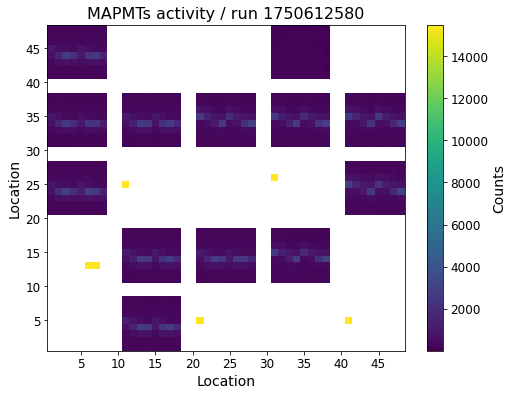

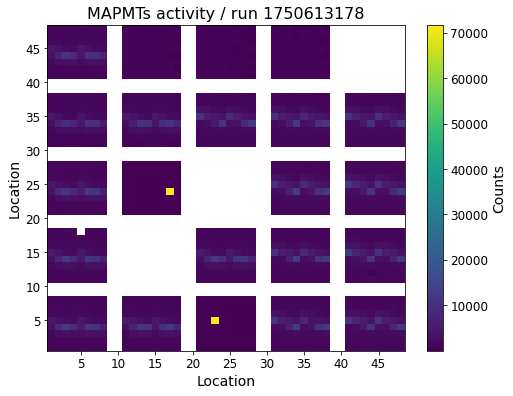

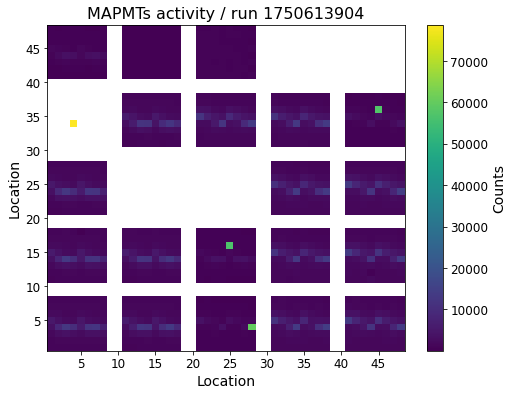

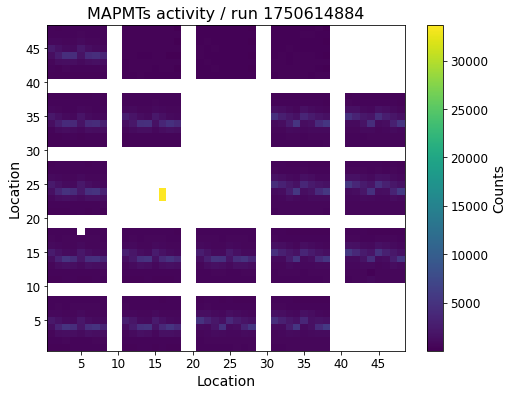

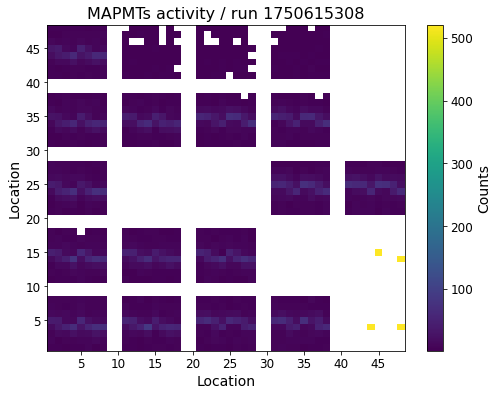

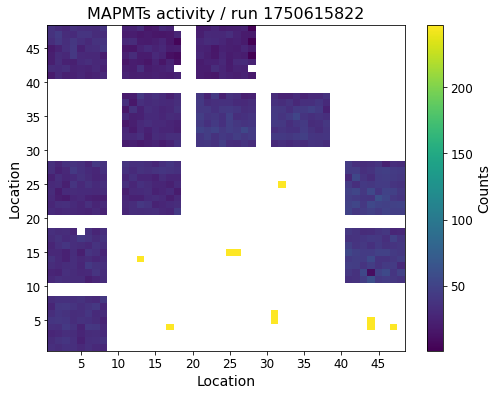

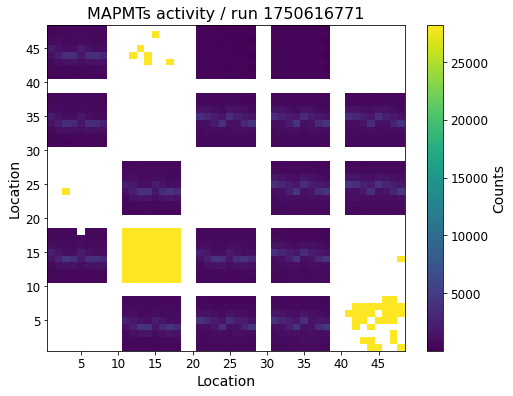

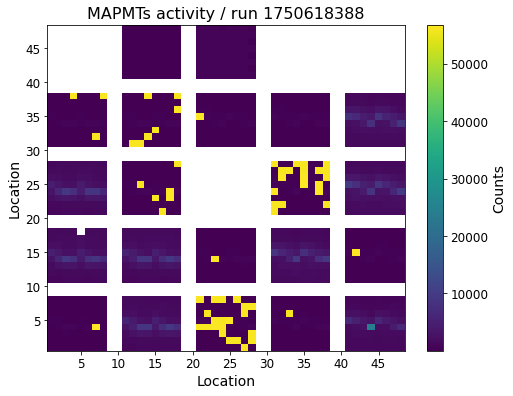

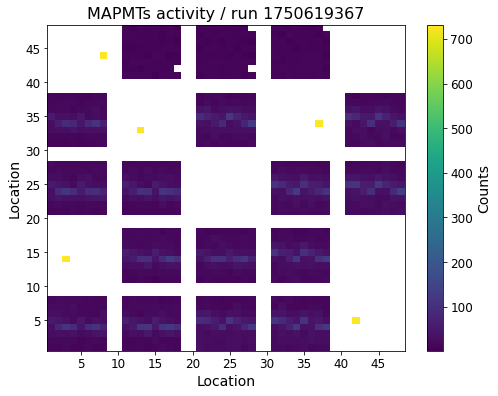

In [24]:
missing_runs = []
empty_runs = []
ok_runs = []

for run in MD_runs:
    fn = f"./all_gnams/gnamFiles/gnam_{run}.root"
    
    if os.path.exists(fn):
        try:
            file = uproot.open(fn)
            if np.sum(file["EXPERT"]["RP_5"]['MAPMTs_activity_1LB'].values()) == 0:
                empty_runs.append(run)
                print(f"Empty histogram for run {run}")
            else:
                plot_MAPMTs_activity(file["EXPERT"]["RP_5"]['MAPMTs_activity_1LB'])
                ok_runs.append(run)
        except Exception as e:
            print(f"Error processing {fn}: {e}")
    else:
        missing_runs.append(run)
        print(f"Missing file for run {run}")

In [25]:
def plot_MAPMTs_activity(hist, save=False, return_values=False, figsize=(8, 6)):
    edges_x = hist.axis(0).edges() 
    edges_y = hist.axis(1).edges() 
    values = hist.values()

    # Fix: ensure values is 2D
    if values.ndim == 3 and values.shape[0] == 1:
        values = values[0]
    elif values.ndim != 2:
        raise ValueError(f"Unexpected shape for histogram values: {values.shape}")

    fig, ax = plt.subplots(figsize=figsize)
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  

    pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)  
    cbar = plt.colorbar(pcm, ax=ax)  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax.set_xlabel("Location", fontsize=14)
    ax.set_ylabel("Location", fontsize=14)
    
    run_number = hist.title.split('_runNb_')[1]
    ax.set_title("MAPMTs activity / run " + run_number, fontsize=16)
    
    ticks = np.arange(5, 50, 5)
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    if save:
        plt.savefig("./Plots/MAPMTs_activity_run_" + run_number + ".png")
    if return_values:
        return fig, ax


In [27]:
missing_runs = []
empty_runs = []
ok_runs = []

pdf = PdfPages("MAPMTs_activity_plots.pdf")

plots_per_page = 4
fig = None
axes = None
plot_index = 0

def plot_MAPMTs_activity_on_ax(hist, ax, run_number):
    try:
        edges_x = hist.axis(0).edges() 
        edges_y = hist.axis(1).edges() 
        values = hist.values()

        # Ensure 2D
        if values.ndim == 3 and values.shape[0] == 1:
            values = values[0]
        elif values.ndim != 2:
            raise ValueError(f"Unexpected shape for histogram values: {values.shape}")

        masked_values = np.ma.masked_where(values == 0, values)  
        cmap = plt.cm.viridis.copy()
        cmap.set_bad(color="white")

        pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)
        ax.set_title(f"Run {run_number}", fontsize=12)
        ax.axis("off")
    except Exception as e:
        ax.text(0.5, 0.5, f"Plot error\nRun {run_number}", ha='center')
        print(f"Plotting error for run {run_number}: {e}")

# Loop over all runs
for run in MD_runs:
    fn = f"./all_gnams/gnamFiles/gnam_{run}.root"

    if not os.path.exists(fn):
        missing_runs.append(run)
        print(f"Missing file for run {run}")
        continue

    try:
        file = uproot.open(fn)
        hist = file["EXPERT"]["RP_5"]['MAPMTs_activity_1LB']
        values = hist.values()

        if np.sum(values) == 0:
            empty_runs.append(run)
            print(f"Empty histogram for run {run}")
            continue

        if plot_index % plots_per_page == 0:
            if fig is not None:
                pdf.savefig(fig)
                plt.close(fig)
            fig, axes = plt.subplots(1, plots_per_page, figsize=(20, 5))
            axes = axes if plots_per_page > 1 else [axes]

        ax = axes[plot_index % plots_per_page]
        plot_MAPMTs_activity_on_ax(hist, ax, run)
        ok_runs.append(run)
        plot_index += 1

    except Exception as e:
        print(f"Error processing {fn}: {e}")

# Save the last page if needed
if fig is not None:
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

print(f"✅ Plots saved to 'MAPMTs_activity_plots.pdf'")
print(f"📁 OK runs: {len(ok_runs)}")
print(f"🚫 Missing runs: {missing_runs}")
print(f"⚠️ Empty histograms: {empty_runs}")

Missing file for run 1750534124
Missing file for run 1750535921
Missing file for run 1750536221
Missing file for run 1750537188
Missing file for run 1750537668
Missing file for run 1750537800
Empty histogram for run 1750540230
Missing file for run 1750541720
Empty histogram for run 1750541947
Empty histogram for run 1750542809
Empty histogram for run 1750543939
Missing file for run 1750544604
Missing file for run 1750544963
Empty histogram for run 1750545288
Empty histogram for run 1750547938
Empty histogram for run 1750548909
Empty histogram for run 1750549591
Missing file for run 1750588528
Missing file for run 1750588675
Missing file for run 1750589655
Missing file for run 1750590046
Missing file for run 1750592719
Missing file for run 1750592892
Missing file for run 1750594018
Missing file for run 1750594599
Missing file for run 1750598647
Missing file for run 1750598934
Missing file for run 1750599213
Missing file for run 1750599857
Missing file for run 1750600315
Missing file for

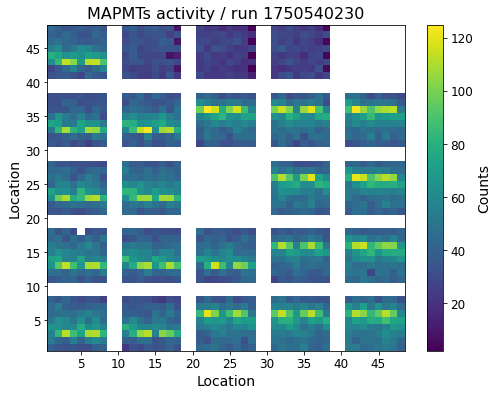

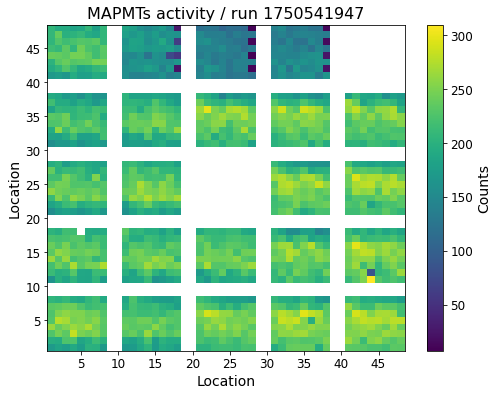

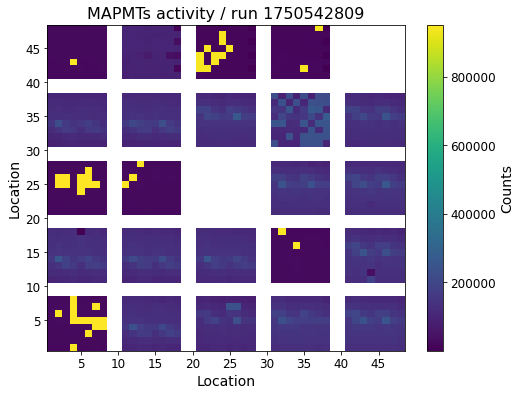

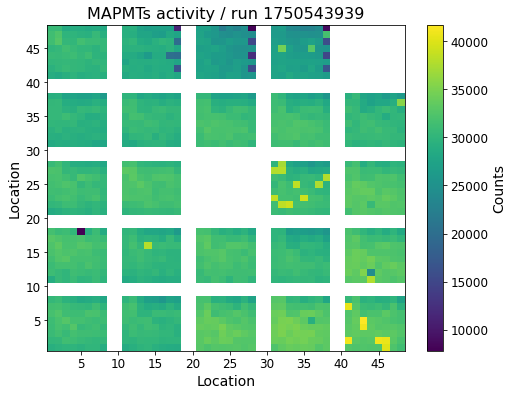

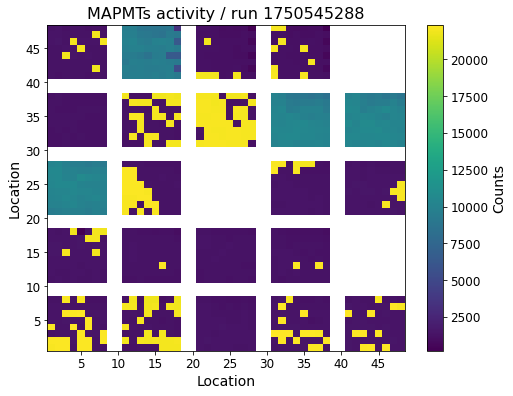

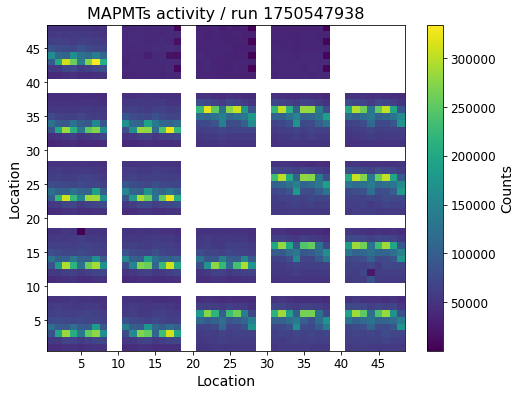

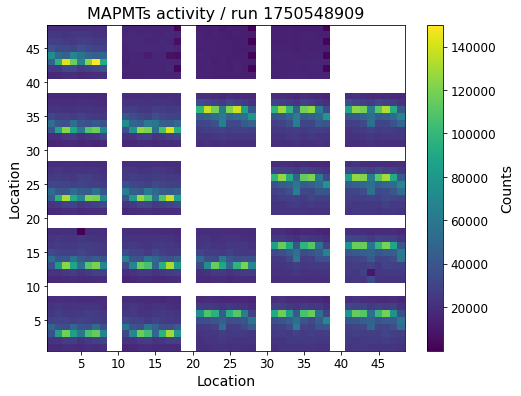

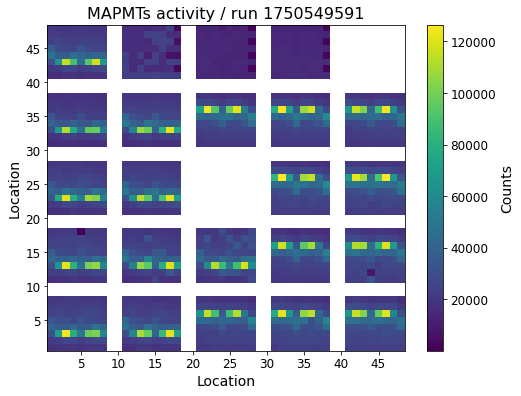

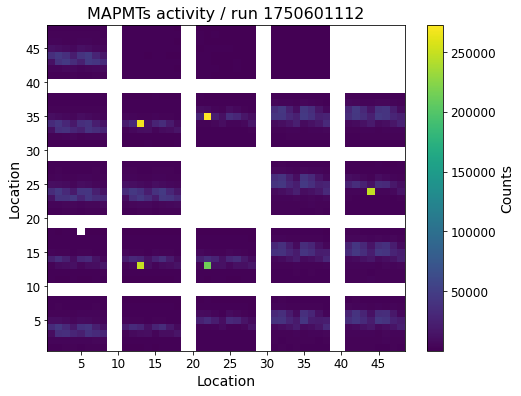

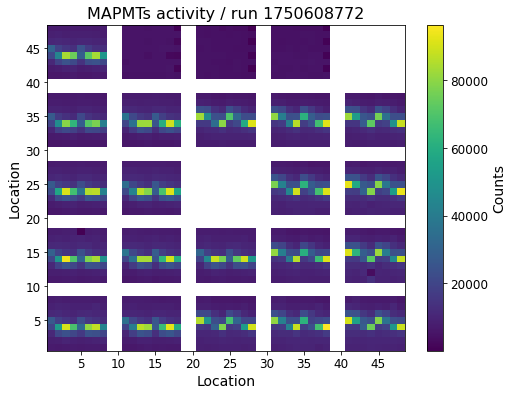

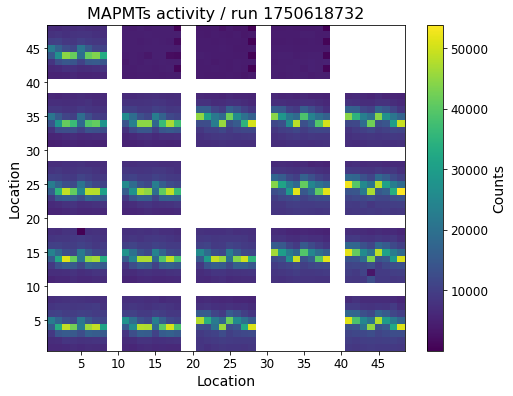

In [26]:
for run in empty_runs:
    fn = f"./all_gnams/gnamFiles/gnam_{run}.root"
    
    if os.path.exists(fn):
        try:
            file = uproot.open(fn)
            plot_MAPMTs_activity(file["EXPERT"]["RP_5"]['MAPMTs_activity'])
        except Exception as e:
            print(f"Error processing {fn}: {e}")

In [29]:
missing_runs

[1750534124,
 1750535921,
 1750536221,
 1750537188,
 1750537668,
 1750537800,
 1750541720,
 1750544604,
 1750544963,
 1750588528,
 1750588675,
 1750589655,
 1750590046,
 1750592719,
 1750592892,
 1750594018,
 1750594599,
 1750598647,
 1750598934,
 1750599213,
 1750599857,
 1750600315,
 1750600490,
 1750604764,
 1750605190,
 1750605465,
 1750606195]

8
Empty run 1750535921
1
129
18
443923
Empty run 1750541720
2067
3
Empty run 1750588528
Empty run 1750588675
Empty run 1750589655
Empty run 1750590046
Empty run 1750592719
Empty run 1750592892
Empty run 1750594018
Empty run 1750594599
Empty run 1750598647
Empty run 1750598934
Empty run 1750599213
Empty run 1750599857
Empty run 1750600315
2141564
Empty run 1750604764
8760
26322
5629


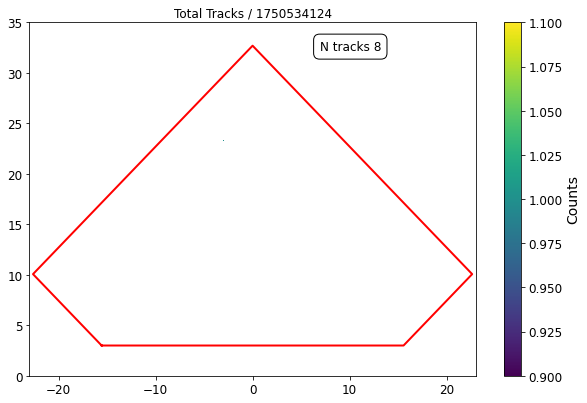

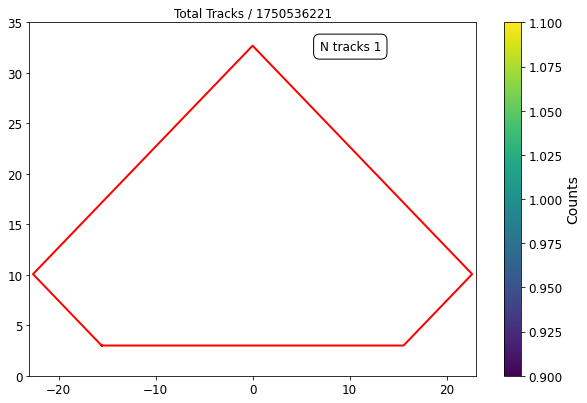

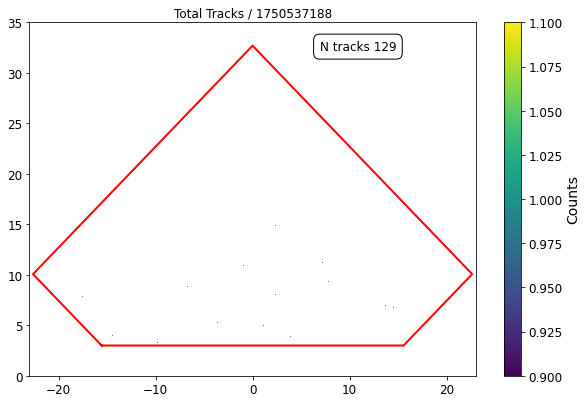

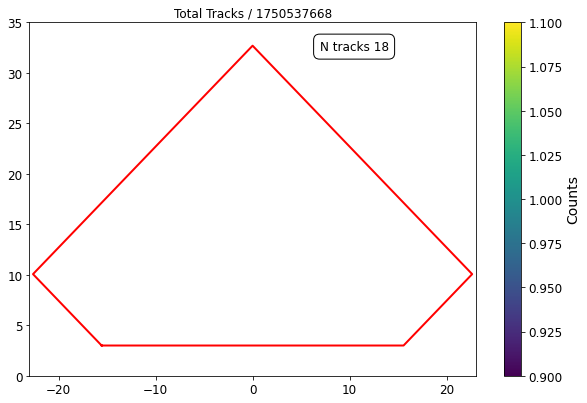

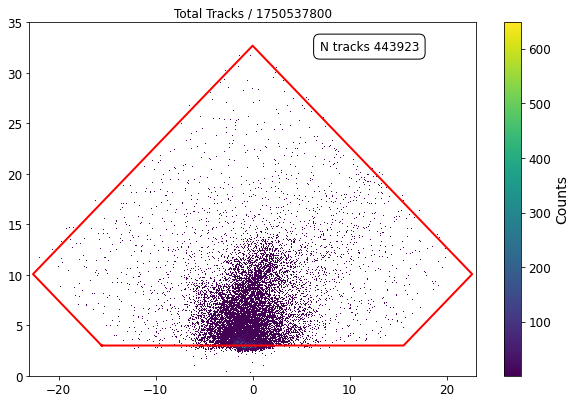

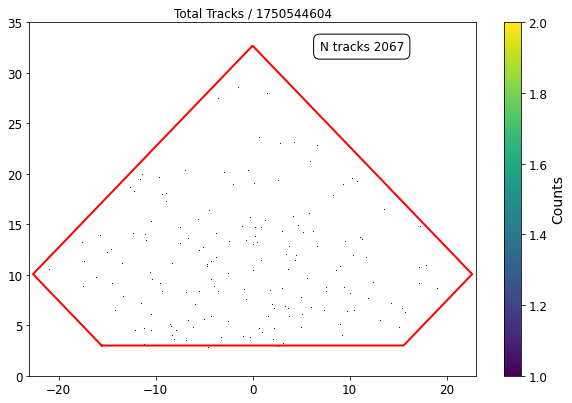

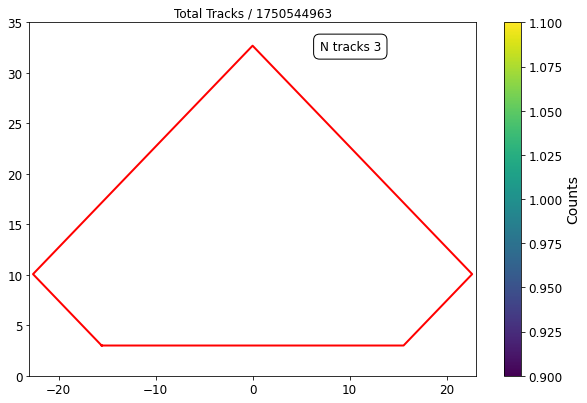

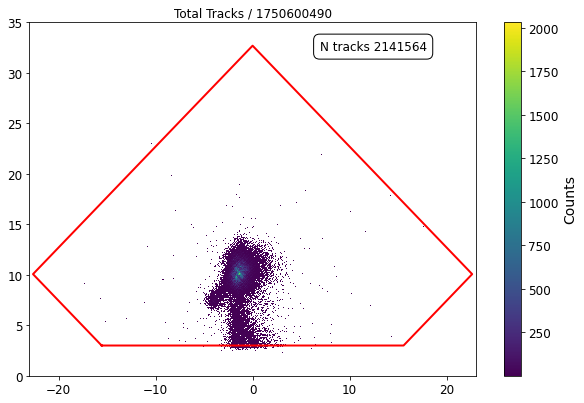

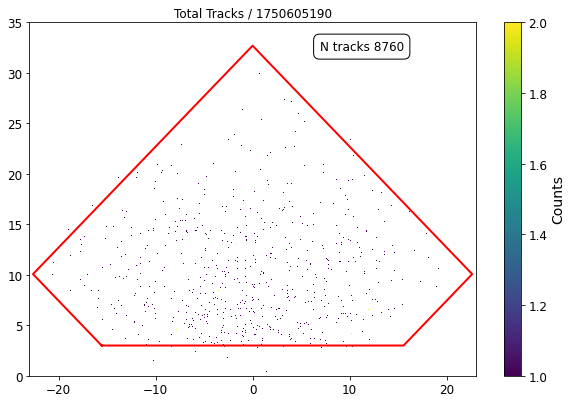

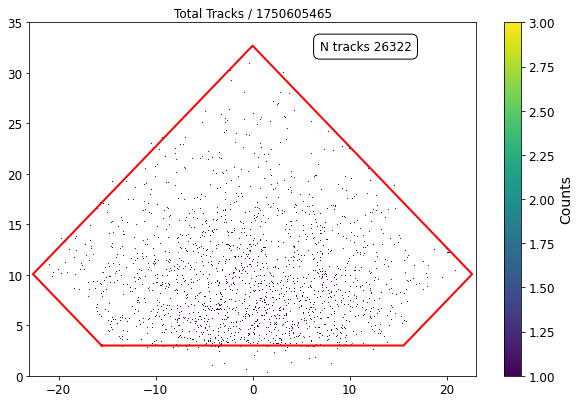

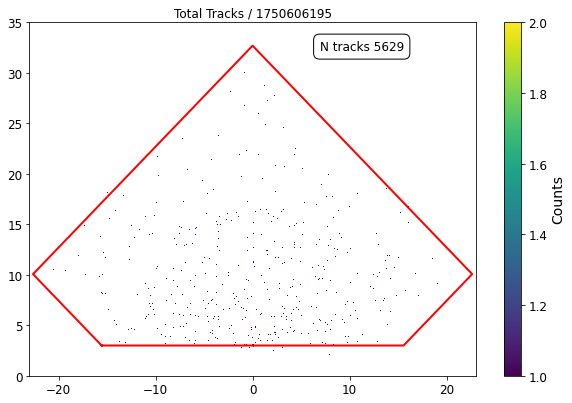

In [38]:
empty_tracks = []
something = []

for t in df_runs.loc[missing_runs].end_time:
    fn = f"/eos/project-t/twocryst/data/tft/snapshots/{find_filename_by_time(t, file_list, runs_info)}"
    r = find_run_number(df_runs, t)
    if os.path.exists(fn):
        try:
            file = uproot.open(fn)  
            h = file[hist_dict["tot"]]  
            if h.values().sum() == 0:
                print(f"Empty run {r}")
                empty_tracks.append(r)
            else:    
                something.append(r)
                file = uproot.open(fn)
                ax = plot_hits(file[hist_dict["tot"]], return_ax = True)
                ax.set_title(f"Total Tracks / {r}")
        except Exception as e:
            print(f"Error processing {fn}: {e}")

In [29]:
something

[1750534124,
 1750536221,
 1750537188,
 1750537668,
 1750537800,
 1750544604,
 1750544963,
 1750600490,
 1750605190,
 1750605465,
 1750606195]

In [37]:
df_empty = df_runs.loc[empty_tracks]
calculate_time_intervals(df_empty)

,start_time,end_time,duration
Run Number,,,
1750535921,2025-06-21 21:58:43,2025-06-21 21:59:06,23.0
1750541720,2025-06-21 23:35:22,2025-06-21 23:38:04,162.0
1750588528,2025-06-22 12:35:29,2025-06-22 12:36:39,70.0
1750588675,2025-06-22 12:37:58,2025-06-22 12:38:43,45.0
1750589655,2025-06-22 12:54:17,2025-06-22 12:54:40,23.0
1750590046,2025-06-22 13:00:49,2025-06-22 13:01:13,24.0
1750592719,2025-06-22 13:45:20,2025-06-22 13:45:20,0.0
1750592892,2025-06-22 13:48:13,2025-06-22 13:59:50,697.0
1750594018,2025-06-22 14:07:00,2025-06-22 14:09:41,161.0


## DF runs

In [79]:
df_MD1 =  filter_runs_by_time_range("2025-06-21 20:00:00", "2025-06-22 04:00:59", df_runs)
MD1_descriptions = {1750534124: "Missing Gnam / before starting", 
 1750535921: "Missing Gnam / before starting", 
 1750536221: "Missing Gnam / before starting", 
 1750537188: "Missing Gnam / Collimators alignment", 
 1750537668: "Missing Gnam / TCCS alignment", 
 1750537800: "Missing Gnam / TCCS angular scan + RPXs alignment",
 1750539655: "OK / Both detetctors and TCCS channeling until it burned with blowup", 
 1750540230: "No last update / TCCS angular scan with blowup until it burned", 
 1750540869: "OK / TCCS angular scan without blowup complete", 
 1750541720: "Empty tracks / TCCP in, TCP retraction and start of angular scan", 
 1750541947: "No last update / TCCP angular scan with blowup", 
 1750542809: "No last update / TFT moving in, datataking of TCCP channeling and angular scan without blowup",
 1750543939: "No last update / moving in pixel",
 1750544604: "Missing Gnam / datataking with pixel", 
 1750544963: "Missing Gnam / datataking with pixel", 
 1750545288: "Missing Gnam /  datataking with pixel (moving PIX closer)", 
 1750546429: "OK / TCCP channeling" , 
 1750547938: "No last update / Move at limit then move out by 1 PIX and normal datataking", #!!
 1750548909:  "No last update / TCCP datataking + move TFT a bit put", 
 1750549591:  "No last update / TCCP angular scan" }#!!}

df_MD1['Description'] = df_MD1.index.map(MD1_descriptions.get)

In [83]:
df_MD1

,start_time,end_time,Description
Run Number,,,
1750534124,2025-06-21 21:28:46,2025-06-21 21:50:21,Missing Gnam / before starting
1750535921,2025-06-21 21:58:43,2025-06-21 21:59:06,Missing Gnam / before starting
1750536221,2025-06-21 22:03:44,2025-06-21 22:08:46,Missing Gnam / before starting
1750537188,2025-06-21 22:19:50,2025-06-21 22:22:57,Missing Gnam / Collimators alignment
1750537668,2025-06-21 22:27:50,2025-06-21 22:28:13,Missing Gnam / TCCS alignment
1750537800,2025-06-21 22:30:02,2025-06-21 22:55:28,Missing Gnam / TCCS angular scan + RPXs alignment
1750539655,2025-06-21 23:00:57,2025-06-21 23:09:29,OK / Both detetctors and TCCS channeling until...
1750540230,2025-06-21 23:10:32,2025-06-21 23:15:10,No last update / TCCS angular scan with blowup...
1750540869,2025-06-21 23:21:11,2025-06-21 23:28:33,OK / TCCS angular scan without blowup complete


In [81]:
df_MD2 = filter_runs_by_time_range("2025-06-22 15:00:00", "2025-06-22 21:30:59", df_runs)

MD2_descriptions = {1750598647: "Empty Tracks / Coll alignement", 
 1750598934: "Empty Tracks / Coll alignement", 
 1750599213: "Empty Tracks / XRPV.B4L3 Aligned + 1 pix retracted", 
 1750599857: "Empty Tracks / TCCS angular scan ", 
 1750600315: "Empty Tracks / TCCS in channeling - both detectors in", 
 1750600490: "Missing Gnam / TCCS in channeling - both detectors in",
 1750601112: "No last update / moving in + TCCS angular scan + moving out", 
 1750602071: "Ok / TCCP linear alignment but TFT was out", 
 1750604764: "Missing Gnam / Super short run during PIX DC data taking (ang scan)", 
 1750605190: "Missing Gnam / Short run during PIX DC data taking (moving in target)", 
 1750605465: "Missing Gnam / Run during PIX DC data taking (target datataking)", 
 1750606195:  "Missing Gnam /  Everything out",
 1750607184: "OK / DC run with TFT", 
 1750607937: "OK / DC run with TFT", 
 1750608772: "No last update / TFT DC scan [-2516., -2517., -2518., -2519., -2520.]",#(2516 ,2517, 2518, 2519, 2520)", 
 1750609459: "OK / TFT DC scan ([-2519., -2520., -2521.])", 
 1750609911: "OK / TFT DC scan ([-2519., -2520., -2521., -2522., -2523., -2524., -2525.]))", 
 1750610787: "OK / TFT DC scan ([-2524., -2525., -2526.]))",
 1750611261: "OK / TFT DC scan ([-2524., -2525., -2526., -2527., -2528., -2529.]))", 
 1750611926: "OK / TFT DC scan ([-2528., -2529., -2530., -2532., -2534., -2536., -2538.]))",
 1750612580: "OK / TFT DC scan ([-2538., -2540., -2542., -2544., -2546.]))", 
 1750613178: "OK / TFT DC scan ([-2538.  , -2539.22, -2546.  , -2547.14, -2548.  , -2549.17, -2550.  , -2552.  , -2554.  , -2556.  , -2558.  ]))",
 1750613904: "OK / TFT DC scan ([-2558., -2560., -2562., -2564., -2566., -2568., -2570., -2572., -2574., -2576., -2578.]))",
 1750614884: "OK / TFT DC scan ([-2576., -2578.]))",
 1750615308: "OK / TFT DC scan ([-2578., -2580., -2582., -2584.]))",
 1750615822: "OK / TFT DC scan ([-2584., -2586., -2588., -2590., -2592.]))",
 1750616771: "OK / Long Run while moving in the target and taking data",
 1750618388: "OK / TCCP fast scan with target ", 
 1750618732: "No last update/ TCCP slow scan with target ([-2530., -2530.41, -2540.71, -2550., -2560.71, -2570., -2580., -2580.74, -2590.  ])", 
 1750619367: "OK / TCCP slow scan with target (-2590.  , -2610.) and moving out "}

df_MD2['Description'] = df_MD2.index.map(MD2_descriptions.get)

In [82]:
df_MD2

,start_time,end_time,Description
Run Number,,,
1750598647,2025-06-22 15:24:08,2025-06-22 15:24:31,Empty Tracks / Coll alignement
1750598934,2025-06-22 15:28:56,2025-06-22 15:28:56,Empty Tracks / Coll alignement
1750599213,2025-06-22 15:33:35,2025-06-22 15:35:07,Empty Tracks / XRPV.B4L3 Aligned + 1 pix retra...
1750599857,2025-06-22 15:44:19,2025-06-22 15:44:42,Empty Tracks / TCCS angular scan
1750600315,2025-06-22 15:51:57,2025-06-22 15:52:20,Empty Tracks / TCCS in channeling - both detec...
1750600490,2025-06-22 15:54:52,2025-06-22 15:58:45,Missing Gnam / TCCS in channeling - both detec...
1750601112,2025-06-22 16:05:15,2025-06-22 16:17:39,No last update / moving in + TCCS angular scan...
1750602071,2025-06-22 16:21:13,2025-06-22 16:30:09,Ok / TCCP linear alignment but TFT was out
1750604764,2025-06-22 17:06:06,2025-06-22 17:06:06,Missing Gnam / Super short run during PIX DC d...


In [ ]:
n = 1750549591


print(runs_info[n])
print(f"n in ok runs: {n in ok_runs}")
print(f"n in missing tracks: {n in missing_runs}")
print(f"n in empty runs: {n in empty_runs}")
print("n in empty tracks: ", n in empty_tracks)

In [80]:
import pytimber as pt
lbd = pt.LoggingDB(source='nxcals', spark_session=spark, )
fromTimber = lbd.get("TCCP.4L3.B2:Acquisition:controllerPosition_rotational", runs_info[n]['start_time'], runs_info[n]['end_time'])
np.sort(np.unique(fromTimber["TCCP.4L3.B2:Acquisition:controllerPosition_rotational"][1]))[::-1]

25/06/30 18:35:41 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@54bfc0a6{/SQL,null,AVAILABLE,@Spark}
25/06/30 18:35:41 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@40d63b46{/SQL/json,null,AVAILABLE,@Spark}
25/06/30 18:35:41 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@459906b2{/SQL/execution,null,AVAILABLE,@Spark}
25/06/30 18:35:41 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@aa25236{/SQL/execution/json,null,AVAILABLE,@Spark}
25/06/30 18:35:41 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@25ce9b01{/static/sql,null,AVAILABLE,@Spark}
